In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install gdown --quiet
!pip install opencv-python matplotlib torchvision --quiet
!pip install av --quiet

In [4]:
import os

non_shoplifters_dir = '/kaggle/input/shop-dataset/Shop DataSet/non shop lifters'
shoplifters_dir = '/kaggle/input/shop-dataset/Shop DataSet/shop lifters'

# Count files in each directory
num_non_shoplifters = len(os.listdir(non_shoplifters_dir))
num_shoplifters = len(os.listdir(shoplifters_dir))

print(f"Number of videos in non shoplifters directory: {num_non_shoplifters}")
print(f"Number of videos in shoplifters directory: {num_shoplifters}")


Number of videos in non shoplifters directory: 531
Number of videos in shoplifters directory: 324


# Preprocessing

In [19]:
import os
import cv2

# Define directories for shoplifters and non-shoplifters
video_dirs = {
    "shoplifters": "/kaggle/input/shop-dataset/Shop DataSet/shop lifters",
    "non_shoplifters": "/kaggle/input/shop-dataset/Shop DataSet/non shop lifters"
}

# Create directories to store extracted frames
frame_dirs = {label: f"/kaggle/working/frames_{label}" for label in video_dirs.keys()}
for dir_name in frame_dirs.values():
    os.makedirs(dir_name, exist_ok=True)

def extract_frames(video_path, output_dir, frame_interval, max_frames=None):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    total_frames = 0
    success = True
    while success:
        success, frame = cap.read()
        if frame_count % frame_interval == 0 and success:
            frame_filename = os.path.join(output_dir, f"frame_{total_frames}.jpg")
            cv2.imwrite(frame_filename, frame)
            total_frames += 1
        frame_count += 1

        # Stop if we've reached the maximum number of frames (for non-shoplifters)
        if max_frames and total_frames >= max_frames:
            break
    cap.release()

# Extract frames with different strategies for each class
for label, video_dir in video_dirs.items():
    for video_file in os.listdir(video_dir):
        video_path = os.path.join(video_dir, video_file)
        if label == "non_shoplifters":
            extract_frames(video_path, frame_dirs[label], frame_interval=3)
        else:
            extract_frames(video_path, frame_dirs[label], frame_interval=1)  # More frames for shoplifters


In [20]:
import os

non_shoplifters_dir = '/kaggle/working/frames_non_shoplifters'
shoplifters_dir = '/kaggle/working/frames_shoplifters'

# Count files in each directory
num_non_shoplifters = len(os.listdir(non_shoplifters_dir))
num_shoplifters = len(os.listdir(shoplifters_dir))

print(f"Number of frames in non shoplifters directory: {num_non_shoplifters}")
print(f"Number of frames in shoplifters directory: {num_shoplifters}")


Number of frames in non shoplifters directory: 617
Number of frames in shoplifters directory: 570


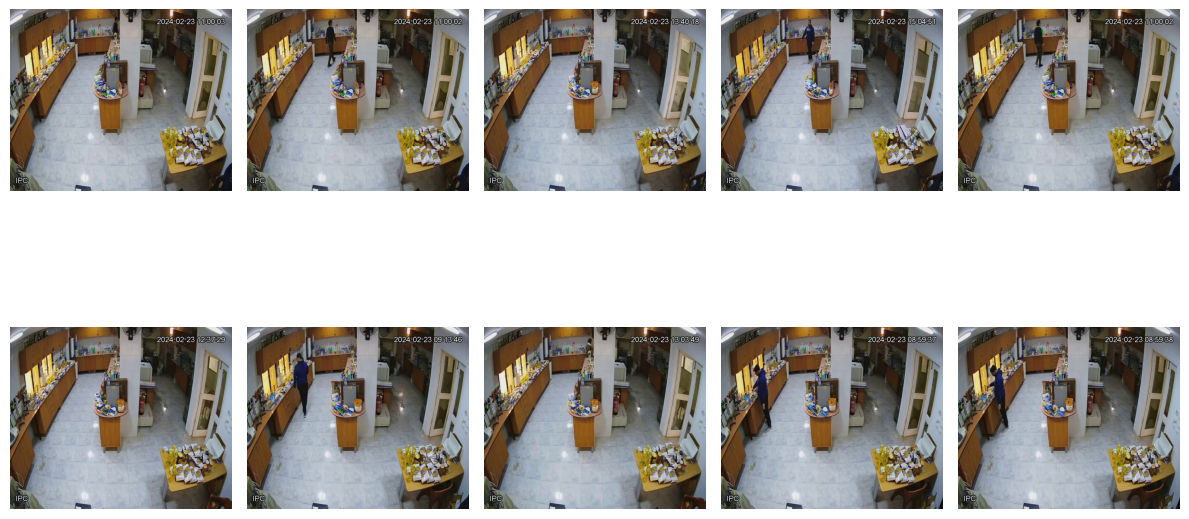

In [21]:
import matplotlib.pyplot as plt
import random
from glob import glob

# Function to display images in a grid
def display_frames(frames, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()
    for img_path, ax in zip(frames, axes):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for displaying
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Randomly select frames to display from both categories
sample_frames_shoplifters = random.sample(glob(f"{frame_dirs['shoplifters']}/*.jpg"), 5)
sample_frames_non_shoplifters = random.sample(glob(f"{frame_dirs['non_shoplifters']}/*.jpg"), 5)

# Display the frames in a grid
display_frames(sample_frames_shoplifters + sample_frames_non_shoplifters)


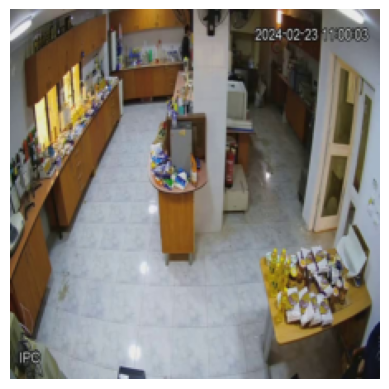

In [22]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Define the transformation
resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Convert to Tensor
])

# Example of applying the transformation
img_path = sample_frames_shoplifters[0]  # Pick a random frame from your list
img = Image.open(img_path)
img_resized = resize_transform(img)

# Display the resized image
plt.imshow(img_resized.permute(1, 2, 0))  # permute to change the order of dimensions
plt.axis("off")
plt.show()


In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_video
from torchvision import transforms
import numpy as np


In [8]:


class VideoDataset(Dataset):
    def __init__(self, video_dirs, transform=None, num_frames=100):
        self.video_paths = []
        self.labels = []
        self.transform = transform
        self.num_frames = num_frames

        # Load video paths and corresponding labels
        for label, video_dir in video_dirs.items():
            for video_file in os.listdir(video_dir):
                self.video_paths.append(os.path.join(video_dir, video_file))
                self.labels.append(label)  # Append the corresponding label

        # Convert labels to a numerical format
        self.label_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}
        self.labels = [self.label_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        video, _, _ = read_video(video_path)  # Read video

        # Video shape: [num_frames, height, width, channels]
        video = video.permute(0, 3, 1, 2)  # Rearrange to [num_frames, channels, height, width]

        # Get the total number of frames in the video
        total_frames = video.shape[0]

        # Sample frames uniformly to ensure representation from all parts of the video
        if total_frames > self.num_frames:
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)  # Select `num_frames` indices uniformly
            video = video[indices]
        elif total_frames < self.num_frames:
            # Pad with black frames if the video has fewer frames than needed
            padding = torch.zeros(self.num_frames - total_frames, *video.shape[1:])
            video = torch.cat((video, padding), dim=0)

        if self.transform:
            video = self.transform(video)  # Apply transform

        label = torch.tensor(label)  # Convert label to tensor
        return video, label


In [9]:
class VideoTransform:
    def __init__(self, frame_size=(128, 128), num_frames=100):
        self.frame_size = frame_size
        self.num_frames = num_frames

    def __call__(self, video):
        # Resize frames and ensure we have num_frames
        resized_frames = []
        for i in range(min(video.shape[0], self.num_frames)):
            frame = transforms.ToPILImage()(video[i])  # Convert to PIL
            frame = frame.resize(self.frame_size)  # Resize
            frame = transforms.ToTensor()(frame)  # Convert back to tensor
            resized_frames.append(frame)

        # Pad with zeros if there are fewer frames than num_frames
        while len(resized_frames) < self.num_frames:
            resized_frames.append(torch.zeros(3, *self.frame_size))

        return torch.stack(resized_frames)  # Shape: [num_frames, channels, height, width]


# 3d CNN Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VideoClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VideoClassifier, self).__init__()
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2))

        self.num_frames = 100
        self.height = 128
        self.width = 128

        # Calculate the output size after the convolutions and pooling
        self.fc_input_size = self.calculate_fc_input_size()

        self.fc1 = nn.Linear(self.fc_input_size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, num_classes)  # Final layer for classification

    def calculate_fc_input_size(self):
        # Dummy input to calculate the output size after conv layers
        x = torch.zeros(1, 3, self.num_frames, self.height, self.width)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x.numel()  # Number of elements in the tensor

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print("Shape after convolutions:", x.shape)  # Check the shape

        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Prepare data
video_dirs = {
    "shoplifters": "/kaggle/input/shop-dataset/Shop DataSet/shop lifters",
    "non_shoplifters": "/kaggle/input/shop-dataset/Shop DataSet/non shop lifters"
}

transform = VideoTransform(frame_size=(128, 128), num_frames=100)
dataset = VideoDataset(video_dirs, transform=transform)

# Split dataset into train, validation, and test sets (70% train, 15% validation, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Initialize model, loss function, and optimizer
num_classes = len(set(dataset.labels))  # Number of unique labels
model = VideoClassifier(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation
        for videos, labels in dataloader:
            videos = videos.permute(0, 2, 1, 3, 4)  # Change shape to [batch_size, channels, num_frames, height, width]
            outputs = model(videos)
            loss = criterion(outputs, labels)  # Compute validation loss
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store all predictions and labels for F1 score calculation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)

    # Calculate Precision, Recall, and F1 Score
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, avg_loss, precision, recall, f1


In [13]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for videos, labels in train_loader:
        videos = videos.permute(0, 2, 1, 3, 4)  # Change shape to [batch_size, channels, num_frames, height, width]
        
        optimizer.zero_grad()
        outputs = model(videos)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Validation after each epoch with F1 score
    val_accuracy, val_loss, val_precision, val_recall, val_f1 = evaluate(model, val_loader, criterion)

    print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}% | '
          f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')



/opt/conda/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Epoch [1/5] | Train Loss: 1.5323, Train Accuracy: 65.72% | Validation Loss: 0.5820, Validation Accuracy: 73.44% | Precision: 0.8487, Recall: 0.7344, F1 Score: 0.7366


/opt/conda/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Epoch [2/5] | Train Loss: 0.2958, Train Accuracy: 85.45% | Validation Loss: 0.1808, Validation Accuracy: 93.75% | Precision: 0.9375, Recall: 0.9375, F1 Score: 0.9375


/opt/conda/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Epoch [3/5] | Train Loss: 0.0989, Train Accuracy: 96.32% | Validation Loss: 0.1055, Validation Accuracy: 95.31% | Precision: 0.9541, Recall: 0.9531, F1 Score: 0.9533


/opt/conda/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Epoch [4/5] | Train Loss: 0.0455, Train Accuracy: 98.83% | Validation Loss: 0.1065, Validation Accuracy: 94.53% | Precision: 0.9457, Recall: 0.9453, F1 Score: 0.9454


/opt/conda/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Epoch [5/5] | Train Loss: 0.0311, Train Accuracy: 98.83% | Validation Loss: 0.0458, Validation Accuracy: 98.44% | Precision: 0.9847, Recall: 0.9844, F1 Score: 0.9843


In [14]:
# Test the model after training
test_accuracy, test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}% | '
      f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')


/opt/conda/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Test Loss: 0.1009, Test Accuracy: 98.45% | Precision: 0.9849, Recall: 0.9845, F1 Score: 0.9844


In [16]:
# Save the entire model state
torch.save({
    'model_state_dict': model.state_dict(),
}, '3dcnn.pth')

print("Model saved successfully!")

Model saved successfully!


In [17]:
import torch
import h5py

# Save model state to .h5 format
def save_model_h5(model, file_name):
    # Create a new HDF5 file
    with h5py.File(file_name, 'w') as h5file:
        # Save the model state_dict
        for key, value in model.state_dict().items():
            h5file.create_dataset(key, data=value.cpu().numpy())  # Move tensor to CPU and convert to numpy

# Example usage
save_model_h5(model, '3dcnn.h5')
print("Model saved successfully in .h5 format!")


Model saved successfully in .h5 format!


In [18]:
import torch

# Assuming `model` is your instance of VideoClassifier
torch.save({
    'model_state_dict': model.state_dict(),
}, '3dcnn.pt')  # Change the file extension to .pt

print("Model saved successfully as 3dcnn.pt!")


Model saved successfully as 3dcnn.pt!
